<a href="https://colab.research.google.com/github/MaviRogar/pytorch_for_dl_specialization_deeplearning.ai/blob/main/notebooks/C1_M1_Lab_2_activation_functions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
%cd /content/pytorch_for_dl_specialization_deeplearning.ai
!git pull
import sys
sys.path.append('/content/pytorch_for_dl_specialization_deeplearning.ai/src')

/content/pytorch_for_dl_specialization_deeplearning.ai
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 4 (delta 1), reused 4 (delta 1), pack-reused 0 (from 0)
Unpacking objects: 100% (4/4), 1.78 KiB | 909.00 KiB/s, done.
From https://github.com/MaviRogar/pytorch_for_dl_specialization_deeplearning.ai
   b5adaa1..b0e64bc  main       -> origin/main
Updating b5adaa1..b0e64bc
Fast-forward
 src/helper_utils_C1_M1_Lab_2.py | 156 ++++++++++++++++++++++++++++++++++++++++
 1 file changed, 156 insertions(+)
 create mode 100644 src/helper_utils_C1_M1_Lab_2.py


# Modeling Non-Linear Patterns with Activation Functions

Welcome back to the delivery challenge!

In the last lab, your simple linear model performed well on bike-only data, but it struggled when cars were added. The reason was simple: your model could only learn **straight lines**, but the new data followed a **curve**. As you saw in the lectures, simply adding more linear neurons is not the solution. The model's output would still be a straight line.

This is where **non-linear activation functions** come in. They are the key to unlocking your model's ability to learn the complex, curved patterns found in real-world data. In this lab, you'll use the most popular and powerful activation function, **ReLU (Rectified Linear Unit)**, to build a more sophisticated model. By adding a ReLU activation, your model can create multiple "bends" that can approximate the complex delivery time curve.

In this lab, you will:

* Prepare the combined bike and car delivery data, this time applying a technique called **normalization** to help your model train more effectively.
* Build a *non-linear* neural network using the **ReLU** activation function.
* Train your new model to learn the complex, curved relationship in the data.
* Predict delivery times using your new model and see if it can finally succeed where the linear one failed.

## Imports

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim

import helper_utils_C1_M1_Lab_2

## Preparing the Non-Linear Data

Start by loading the same dataset that caused problems at the end of the last lab. This is the combined data for both bike and car deliveries.

In [7]:
# Combined dataset: bikes for short distances, cars for longer ones
distances = torch.tensor([
    [1.0], [1.5], [2.0], [2.5], [3.0], [3.5], [4.0], [4.5], [5.0], [5.5],
    [6.0], [6.5], [7.0], [7.5], [8.0], [8.5], [9.0], [9.5], [10.0], [10.5],
    [11.0], [11.5], [12.0], [12.5], [13.0], [13.5], [14.0], [14.5], [15.0], [15.5],
    [16.0], [16.5], [17.0], [17.5], [18.0], [18.5], [19.0], [19.5], [20.0]
], dtype=torch.float32)

# Corresponding delivery times in minutes
times = torch.tensor([
    [6.96], [9.67], [12.11], [14.56], [16.77], [21.7], [26.52], [32.47], [37.15], [42.35],
    [46.1], [52.98], [57.76], [61.29], [66.15], [67.63], [69.45], [71.57], [72.8], [73.88],
    [76.34], [76.38], [78.34], [80.07], [81.86], [84.45], [83.98], [86.55], [88.33], [86.83],
    [89.24], [88.11], [88.16], [91.77], [92.27], [92.13], [90.73], [90.39], [92.98]
], dtype=torch.float32)

* As you will see from running the code below, the data plot follows a non-linear pattern.

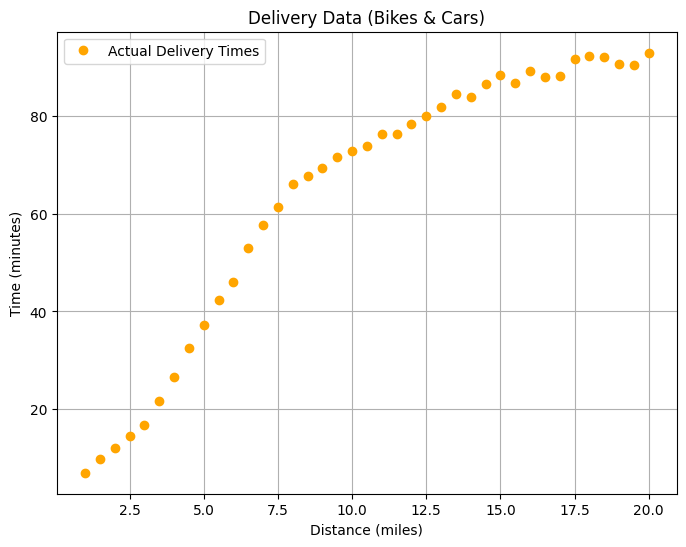

In [9]:
helper_utils_C1_M1_Lab_2.plot_data(distances, times)

### A New Step: Normalizing the Data

Before building your model, you will apply a quick data preparation step called **normalization**. This is a standard technique that makes the training process more stable and effective by adjusting the scale of the data. This adjustment helps prevent large distance values from dominating the learning process and keeps gradients stable during training. You will explore this topic in greater detail in a later module.

* You will calculate the mean and standard deviation for the `distances` and `times` tensors.
* You will then apply standardization to each tensor using its respective mean and standard deviation, which creates new normalized tensors named `distances_norm` and `times_norm`.
* This specific technique is called **standardization** (or z-score normalization), which converts the original data from `1.0 to 20.0 miles` and approximately `7 to 93 minutes` into a new, normalized scale.

In [10]:
# Calculate the mean and standard deviation for the 'distances' tensor
distances_mean = distances.mean()
distances_std = distances.std()

# Calculate the mean and standard deviation for the 'times' tensor
times_mean = times.mean()
times_std = times.std()

# Apply standardization to the distances.
distances_norm = (distances - distances_mean) / distances_std

# Apply standardization to the times.
times_norm = (times - times_mean) / times_std

* You will notice the axes now show the data on a new, normalized scale, with distance ranging from approximately `-1.7 to 1.7` and time from `-2.0 to 1.0`.
* Despite this change in scale, the underlying curved pattern of the data remains exactly the same.

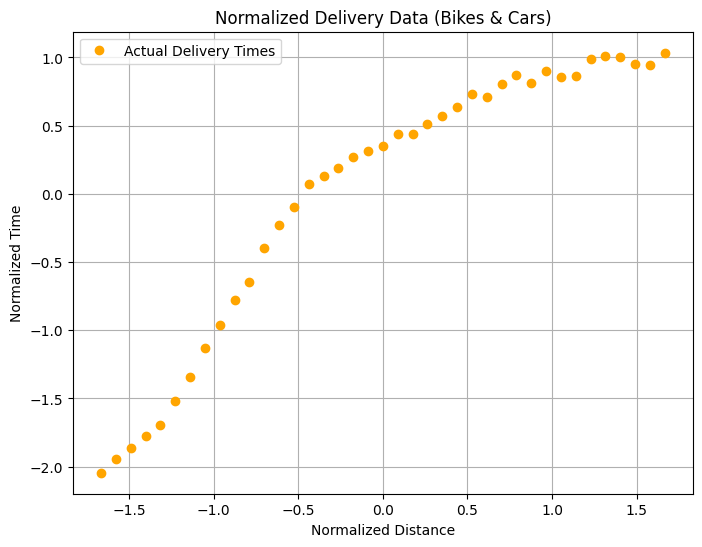

In [12]:
helper_utils_C1_M1_Lab_2.plot_data(distances_norm, times_norm, normalize=True)

## Building the Non-Linear Model

With your normalized data ready, you can now build a model capable of learning its curved pattern. You will define the model's architecture, which now includes a `ReLU` activation function. This structure is what gives your model the ability to learn non-linear relationships.

* `nn.Linear(1, 3)`: This is your **first hidden layer**. It consists of three neurons, each receiving one input feature (the normalized distance). This layer transforms the single input value into three separate values.
* `nn.ReLU()` applies the ReLU activation function to the output of each of the three neurons from the hidden layer. This is the crucial non-linear step that allows your model to create "bends" and learn curves instead of just straight lines.
* `nn.Linear(3, 1)`: This is your **output layer**. It takes the three activated values from the previous step as its input and combines them to produce a single final output, which is your predicted (normalized) delivery time.

This creates a neural network with 1 hidden layer containing 3 neurons.

In [13]:
# This line ensures that your results are reproducible and consistent every time.
torch.manual_seed(27)

model = nn.Sequential(
    nn.Linear(1, 3),
    nn.ReLU(),
    nn.Linear(3, 1)
)

## Training

* Define the loss function and the optimizer for training.

In [14]:
# Define the loss function and optimizer
loss_function = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

With your model and training tools ready, you can begin the training process.

* You will run the training loop for `3000` epochs (more than Lab 1 because the non-linear pattern is more complex and requires more training). This will repeatedly feed the *normalized* data to your model, measure the error, and adjust the model's parameters to improve its predictions.
* The second half of the code includes a live plot, allowing you to watch in real time as your model's prediction line adapts to fit the curved data. The live plot helps you see how your model gradually learns to fit the curve, starting with a poor fit and improving over time.

**IMPORTANT NOTE**: As the plot updates in real time during training, you might notice a flickering effect. This is the expected behavior of the live visualization and not an issue with your screen.

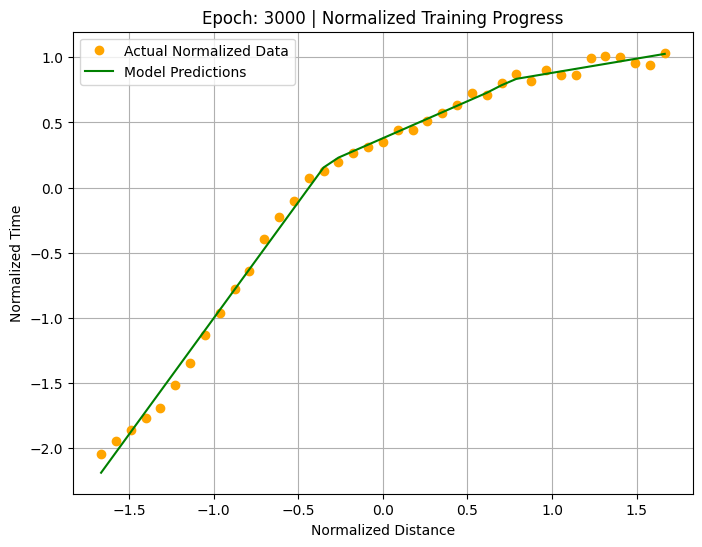


Training Complete.

Final Loss: 0.0031364739406853914


In [16]:
# Training loop
for epoch in range(3000):
    # Reset the optimizer's gradients
    optimizer.zero_grad()
    # Make predictions (forward pass)
    outputs = model(distances_norm)
    # Calculate the loss
    loss = loss_function(outputs, times_norm)
    # Calculate adjustments (backward pass)
    loss.backward()
    # Update the model's parameters
    optimizer.step()

    # Create a live plot every 50 epochs
    if (epoch + 1) % 50 == 0:
        helper_utils_C1_M1_Lab_2.plot_training_progress(
            epoch=epoch,
            loss=loss,
            model=model,
            distances_norm=distances_norm,
            times_norm=times_norm
        )

print("\nTraining Complete.")
print(f"\nFinal Loss: {loss.item()}")

## Checking the Final Fit

Now that training is complete, you will visualize the result.

* You will plot your model's final predicted curve against the original data points.
* This lets you visually inspect how well your non-linear model learned to fit the complex data pattern.

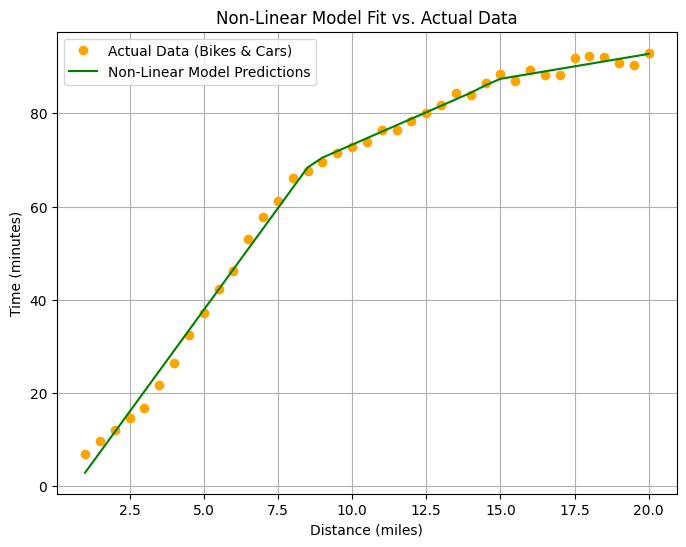

In [17]:
helper_utils_C1_M1_Lab_2.plot_final_fit(model, distances, times, distances_norm, times_std, times_mean)

<br>

Congratulations! You have successfully trained your first **non-linear** neural network in PyTorch!

Where the simple linear model from the last lab failed, your new model with a `ReLU` activation function succeeded. As you can see from the plot, your model learned to capture the complex, curved relationship in the combined bike and car delivery data.

## Making a Prediction

With your fully trained non-linear model, you can now use it to make a prediction for a new delivery. The process is slightly different now because your model was trained on *normalized* data.

* First, you will take the new input distance and **normalize** it using the same mean and standard deviation from your training data. This step is CRITICAL: your model has no idea about the original scales (miles and minutes). It only understands the normalized scale it was trained on.
* After the model provides its prediction, you must **de-normalize** the output. This converts the prediction from its normalized scale back into an understandable value in minutes.
* Finally, the code uses this actual predicted time to run the decision logic. For this prediction, assume your company now promises deliveries within 45 minutes (instead of 30 minutes from Lab 1) and wants to know which vehicle to use.

In [18]:
distance_to_predict = 5.1

In [19]:
# Use the torch.no_grad() context manager for efficient prediction
with torch.no_grad():
    # Normalize the input distance
    distance_tensor = torch.tensor([[distance_to_predict]], dtype=torch.float32)
    new_distance_norm = (distance_tensor - distances_mean) / distances_std

    # Get the normalized prediction from the model
    predicted_time_norm = model(new_distance_norm)

    # De-normalize the output to get the actual time in minutes
    predicted_time_actual = (predicted_time_norm * times_std) + times_mean

    # --- Decision Making Logic ---
    print(f"Prediction for a {distance_to_predict}-mile delivery: {predicted_time_actual.item():.1f} minutes")

    # First, check if the delivery is possible within the 45-minute timeframe
    if predicted_time_actual.item() > 45:
        print("\nDecision: Do NOT promise the delivery in under 45 minutes.")
    else:
        # If it is possible, then determine the vehicle based on the distance
        if distance_to_predict <= 3:
            print(f"\nDecision: Yes, delivery is possible. Since the distance is {distance_to_predict} miles (<= 3 miles), use a bike.")
        else:
            print(f"\nDecision: Yes, delivery is possible. Since the distance is {distance_to_predict} miles (> 3 miles), use a car.")

Prediction for a 5.1-mile delivery: 38.7 minutes

Decision: Yes, delivery is possible. Since the distance is 5.1 miles (> 3 miles), use a car.


## Conclusion

You have now built and trained both a simple linear model and a more powerful non-linear model in PyTorch. In this lab, you saw firsthand how adding a non-linear activation function like **ReLU** gave your model the ability to succeed where the linear model had failed.

You have moved beyond fitting straight lines and can now capture the complex, curved patterns that are common in real-world data. You also learned a practical data preparation technique, normalization, that helps make the training process more stable and effective.

With these fundamental skills of building architectures, preparing data, and training models, you are well prepared for the next step. In the upcoming module, you will build on this foundation to tackle new kinds of problems, like classification, and dive even deeper into the mechanics of how neural networks learn.